In [1]:
from google.colab import drive
drive.mount("/content/drive",force_remount=True)

Mounted at /content/drive


In [2]:
import glob, numpy as np, cv2, matplotlib.pyplot as plt, tensorflow as tf, copy

from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras import Model, callbacks as cb, optimizers
from tensorflow.keras.models import load_model, model_from_json
from tensorflow.keras.layers import Dense, Dropout, Lambda, Input, Conv2D, Conv2DTranspose, concatenate, MaxPooling2D
from tensorflow.keras import Model

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from skimage.filters import rank
from skimage.morphology import disk

In [3]:
%cd "/content/drive/My Drive/Colab Notebooks"

/content/drive/My Drive/Colab Notebooks


## Defining histogram functions

In [4]:
def match_histogram(source, template):
    """
    Adjust the pixel values of a gray-scale image such that its histogram
    matches that of a target image
    Arguments:
    -----------
        source: np.ndarray
            Image to transform; the histogram is computed over the flattened
            array
        template: np.ndarray
            Template image; can have different dimensions to source
    Returns:
    -----------
        matched: np.ndarray
            The transformed output image
    """

    oldshape = source.shape
    source = source.ravel()
    template = template.ravel()

    # get the set of unique pixel values and their corresponding indices and
    # counts
    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True, return_counts=True)
    t_values, t_counts = np.unique(template, return_counts=True)

    # take the cumsum of the counts and normalize by the number of pixels to
    # get the empirical cumulative distribution functions for the source and
    # template images (maps pixel value --> quantile)
    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]

    # interpolate linearly to find the pixel values in the template image
    # that correspond most closely to the quantiles in the source image
    interpolated_t_values = np.interp(s_quantiles, t_quantiles, t_values)
    hist_matched_img = interpolated_t_values[bin_idx].reshape(oldshape)
    result = np.array(hist_matched_img, dtype='uint8')

    return result

In [5]:
def subhist(image_pdf, minimum, maximum, normalize):
    """
    Compute the subhistogram between [minimum, maximum] of a given histogram image_pdf
    :param image_pdf: numpy.array
    :param minimum: int
    :param maximum: int
    :param normalize: boolean
    :return: numpy.array
    """
    hi = np.zeros(shape=image_pdf.shape)
    total = 0
    for idx in range(minimum, maximum+1):
        total += image_pdf[idx]
        hi[idx] = image_pdf[idx]
    if normalize:
        for idx in range(minimum, maximum+1):
            hi[idx] /= total
    return hi


def CDF(hist):
    """
    Compute the CDF of the input histogram
    :param hist: numpy.array()
    :return: numpy.array()
    """
    cdf = np.zeros(shape=hist.shape)
    cdf[0] = hist[0]
    for idx in range(1, len(hist)):
        cdf[idx] = cdf[idx - 1] + hist[idx]
    return cdf


def BEASF(image, gamma):
    """
    Compute the Bi-Histogram Equalization with Adaptive Sigmoid Functions algorithm (BEASF)
    A python implementation of the original MATLAB code:
    https://mathworks.com/matlabcentral/fileexchange/47517-beasf-image-enhancer-for-gray-scale-images
    The algorithm is introduced by E. F. Arriaga-Garcia et al., in the research paper:
    https://ieeexplore.ieee.org/document/6808563
    :param image: numpy.ndarray
    :param gamma: float [0, 1]
    :return: numpy.ndarray
    """
    m = int(np.mean(image, dtype=np.int32))
    h = np.histogram(image, bins=256)[0] / (image.shape[0] * image.shape[1])
    h_lower = subhist(image_pdf=h, minimum=0, maximum=m, normalize=True)
    h_upper = subhist(image_pdf=h, minimum=m, maximum=255, normalize=True)

    cdf_lower = CDF(hist=h_lower)
    cdf_upper = CDF(hist=h_upper)

    # Find x | CDF(x) = 0.5
    half_low = 0
    for idx in range(0, m+2):
        if cdf_lower[idx] > 0.5:
            half_low = idx
            break
    half_up = 0
    for idx in range(m, 256):
        if cdf_upper[idx + 1] > 0.5:
            half_up = idx
            break

    # sigmoid CDF creation
    tones_low = np.arange(0, m+1, 1)
    x_low = 5.0 * (tones_low - half_low) / m  # shift & scale intensity x to place sigmoid [-2.5, 2.5]
    s_low = 1 / (1 + np.exp(-gamma * x_low))  # lower sigmoid

    tones_up = np.arange(m, 256, 1)
    x_up = 5.0 * (tones_up - half_up) / (255 - m)  # shift & scale intensity x to place sigmoid [-2.5, 2.5]
    s_up = 1 / (1 + np.exp(-gamma * x_up))  # upper sigmoid

    mapping_vector = np.zeros(shape=(256,))
    for idx in range(0, m+1):
        mapping_vector[idx] = np.int32(m * s_low[idx])

    minimum = mapping_vector[0]
    maximum = mapping_vector[m]
    for idx in range(0, m+1):
        mapping_vector[idx] = np.int32((m / (maximum - minimum)) * (mapping_vector[idx] - minimum))
    for idx in range(m+1, 256):
        mapping_vector[idx] = np.int32(m + (255 - m) * s_up[idx - m - 1])

    minimum = mapping_vector[m + 1]
    maximum = mapping_vector[255]
    for idx in range(m+1, 256):
        mapping_vector[idx] = (255 - m) * (mapping_vector[idx] - minimum) / (maximum - minimum) + m

    res = copy.deepcopy(image)
    res[:, :] = mapping_vector[image[:, :]]
    return res

In [ ]:
!ls ./covid_cxr_dataset/covid19 -1 | wc -l

ls: cannot access './covid_cxr_dataset/covid19': No such file or directory
0


## Read Data and Convert to npy

In [ ]:
def collect_images_from(path, exclude_early_stages=True, exclude_pediatrics=True):
    normal_images = list()
    for img_name in glob.glob(pathname=path + '/NORMAL/*'):
        img = load_img(path=img_name, color_mode='grayscale')
        img = img_to_array(img=img, data_format='channels_last')
        normal_images.append(img)

    normal_images = np.array(normal_images)
    print('num normal CXRs:', len(normal_images))

    cap_images = list()
    for img_name in glob.glob(pathname=path + '/PNEUMONIA/*'):
        img = load_img(path=img_name, color_mode='grayscale')
        img = img_to_array(img=img, data_format='channels_last')
        cap_images.append(img)

    cap_images = np.array(cap_images)
    print('num community-acquired pneumonia CXRs:', len(cap_images))

    covid_images = list()
    num_early_stage_images = 0
    num_pediatric_images = 0
    for img_name in glob.glob(pathname=path + '/covid19/*'):
        early_stage = False
        pediatric = False
        img_num = img_name[img_name.rfind('\\') + 1:img_name.rfind('.')]
        if ('-' in img_num) & exclude_early_stages:
            num_early_stage_images += 1
            early_stage = True
        if ('p' in img_num) & exclude_pediatrics:
            num_pediatric_images += 1
            pediatric = True

        if early_stage | pediatric:
            continue
        else:
            img = load_img(path=img_name, color_mode='grayscale')
            img = img_to_array(img=img, data_format='channels_last')
            covid_images.append(img)

    print("num total early stage images:", num_early_stage_images)
    print("num total pediatric images:", num_pediatric_images)
    covid_images = np.array(covid_images)
    print('num collected covid CXRs:', len(covid_images))

    normal_labels = [0 for _ in range(len(normal_images))]
    cap_labels = [1 for _ in range(len(cap_images))]
    covid_labels = [2 for _ in range(len(covid_images))]

    X = np.concatenate((covid_images, cap_images, normal_images))
    y = np.array(covid_labels + cap_labels + normal_labels)
    return X, y

In [ ]:
def resize_images_of(X):
    X = np.array([cv2.resize(image, dsize=(320, 320), interpolation=cv2.INTER_CUBIC) for image in X])
    X = np.array([np.expand_dims(a=image, axis=-1) for image in X])
    X = X.astype(dtype=np.uint8)
    return X


def show_random_image_from(X):
    rnd_idx = np.random.choice(a=len(X), size=None)
    plt.imshow(X=X[rnd_idx].squeeze(), cmap='gray')
    plt.axis('off')
    plt.title(label='a random image from the dataset')
    plt.show()


def save_dataset(data, labels):
    print('number of total dataset images:', len(data))
    print('number of total dataset labels:', len(labels))
    print('dataset shape:', data.shape)
    print("export images as npy file? (y/n)")
    if input() == 'y':
        np.save('./cxr_samples_multiclass.npy', arr=data)
        np.save('./cxr_labels_multiclass.npy', arr=labels)
    else:
        print('dataset exportation aborted.')

In [ ]:
data_path = './covid_cxr_dataset/'

X, y = collect_images_from(path=data_path, exclude_early_stages=True, exclude_pediatrics=True)


num normal CXRs: 0
num community-acquired pneumonia CXRs: 0
num total early stage images: 0
num total pediatric images: 0
num collected covid CXRs: 0


In [ ]:
X = resize_images_of(X=X)
show_random_image_from(X=X)
save_dataset(data=X, labels=y)

ValueError: ignored

# Dataset Preparation

number of total dataset images: 300
number of total dataset labels: 300
dataset shape: (300,)


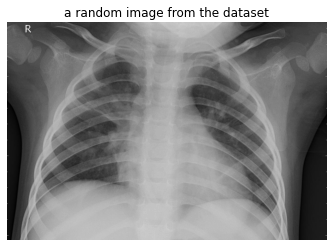

In [10]:
X = np.load(file='/content/drive/My Drive/Colab Notebooks/train_cxr_samples.npy',allow_pickle=True)
y = np.load(file='/content/drive/My Drive/Colab Notebooks/train_cxr_labels.npy',allow_pickle=True)
X_30 = np.load(file='/content/drive/My Drive/Colab Notebooks/cxr_30_samples.npy')
#y = np.load(file='/content/drive/My Drive/Colab Notebooks/cxr_30_labels.npy')

print('number of total dataset images:', len(X))
print('number of total dataset labels:', len(y))
print('dataset shape:', X.shape)

rnd_idx = np.random.choice(a=len(X), size=None)
plt.imshow(X=X[rnd_idx].squeeze(), cmap='gray')
plt.axis('off')
plt.title(label='a random image from the dataset')
plt.show()

In [ ]:
print(X[2].dtype)

float32


In [14]:
print(X_30[1].dtype)

uint8


In [11]:
def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

segmentor = unet(input_size=(320, 320, 1))
# segmentor.summary()
segmentor.load_weights('/content/drive/My Drive/cxr_reg_weights.hdf5')

In [ ]:
X_img = [img_float32.astype(np.uint8) for img_float32 in X]

In [12]:
def do_segmentation(images, disk_rad=40, kernel_size=(5, 5), num_iter=3, margin=0):
    equ_images = [rank.equalize(image.squeeze(), selem=disk(radius=disk_rad)) for image in images]
    masks = [segmentor(np.expand_dims(equ_image, axis=[0, -1])) for equ_image in equ_images]
    masks = [cv2.dilate(np.squeeze(mask), kernel=np.ones(kernel_size), iterations=num_iter) for mask in masks]
    images = [image[np.min(np.where(masks[idx]==1)[0]) - margin:np.max(np.where(masks[idx]==1)[0]) + margin, 
                    np.min(np.where(masks[idx]==1)[1]) - margin:np.max(np.where(masks[idx]==1)[1]) + margin]
              for idx, image in enumerate(images)]
    images = [cv2.resize(image, dsize=(320, 320), interpolation=cv2.INTER_CUBIC) for image in images]
    images = [np.expand_dims(image, axis=-1) for image in images]
    return np.array(images)

In [13]:
X_segmented = do_segmentation(images=X_30)

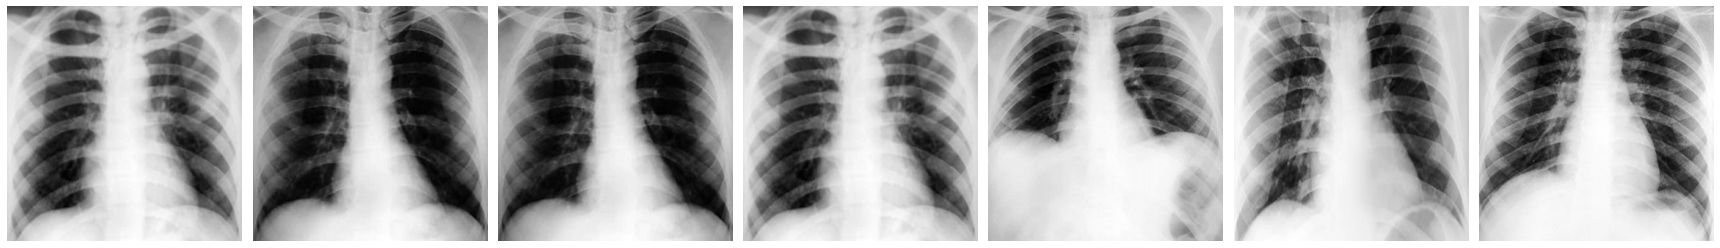

In [ ]:
fig = plt.figure(num=7, figsize=(24, 8))
for i in range(7):
    plt.subplot(1, 7, i+1)
    plt.imshow(X_segmented[np.random.randint(0, len(X_segmented))].squeeze(), cmap='gray')
    plt.axis('off')
fig.tight_layout()
plt.show()

# save the ROI-segmented dataset as npy file
#np.save(file='/content/drive/My Drive/Datasets/covid_cxr_dataset/train_cxr_segmented.npy',
 #       arr=X_segmented)

num COVID-19 images: 10
num normal images: 10
num CAP samples: 10
number of total dataset images: 30
number of total dataset labels: 30
dataset shape: (30, 320, 320, 3)


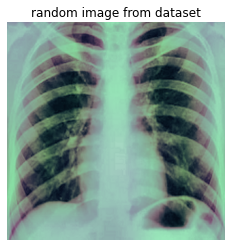

In [ ]:
# run with previously segmented images (ignore 5 last code blocks above)
X = X_segmented
y = y
#X = np.concatenate((X[:695], X[695:4295], X[6000:9600]), axis=0)
#y = np.concatenate((y[:695], y[695:4295], y[6000:9600]))
# X = np.concatenate((X[:500], X[1000:1500], X[5500:6000]), axis=0)
# y = np.concatenate((y[:500], y[1000:1500], y[5500:6000]))

# one-hot encoding of labels
transformer = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0])])
y_reshaped = y.reshape(-1, 1)
y_column_encoded = transformer.fit_transform(y_reshaped)

# compute num images in each class
num_cap_samples = 0
num_covid_samples = 0
num_normal_samples = 0
for idx, img in enumerate(X):
    if y[idx] == 1:
        num_cap_samples += 1
    elif y[idx] == 0:
        num_normal_samples += 1
    else:
        num_covid_samples += 1
print('num COVID-19 images:', num_covid_samples)
print('num normal images:', num_normal_samples)
print('num CAP samples:', num_cap_samples)

# manual label smoothing by 0.1 deviation
# y[np.where(y == 0)] = 0.1
# y[np.where(y == 1)] = 0.9

# perform histogram matching since majority of the images are from NIH-14 dataset
base_image = X[0]
X = np.array([match_histogram(source=image, template=base_image) for image in X])

# apply image enhancements and concat with the original image
X_beasf = np.array([BEASF(image=image, gamma=1.5) for image in X])
X_clahe = np.array([cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(image) for image in X])
X_clahe = np.array([np.expand_dims(a=image, axis=-1) for image in X_clahe])
X = np.concatenate((X_beasf, X_clahe, X), axis=-1)

# rescale images from [0, 255] to [0, 1]
# X = np.array([X[idx] / 255. for idx in range(len(X))])

print('number of total dataset images:', len(X))
print('number of total dataset labels:', len(y))
print('dataset shape:', X.shape)

rnd_idx = np.random.choice(a=len(X), size=None)
plt.imshow(X=X[rnd_idx].squeeze(), cmap='gray')
plt.axis('off')
plt.title(label='random image from dataset')
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, y_column_encoded, test_size=0.2, 
                                                    random_state=18)

# NOTE: sklearn train_test_split function copies the dataset, hence deleting initial data
# variables will increase RAM space drastically (~ x2)
del X, X_beasf, X_clahe

# Retraining and Finetuning

In [ ]:
# IMPORTANT: applying zoom and brightness at the same time will change image pixel range from
# [0, 1] to [0, 255], hence we need to add rescaling again (despite doing it when importing
# dataset). Otherwise, model will see all validation data (not undergone augmentation) as 
# black images giving a same prediction value for all
augmenter = ImageDataGenerator(rotation_range=170, horizontal_flip=True, vertical_flip=True, 
                               zoom_range=[0.8, 1.5], brightness_range=[0.5, 1.3], rescale=1./255,
                               width_shift_range=0.1, height_shift_range=0.1, fill_mode='constant')

# NOTE: Keras ImageDataGenerator does not keep input image default ratio (as of v2.3.1)
# NOTE: Keras ImageDataGenerator does not resize-and-padd when doing rotation (thus 
# loosing part of the image due to cropping while rotating)
#checkpoint = cb.ModelCheckpoint('/content/drive/My Drive/covid_model/eps={epoch:03d}_valLoss={val_loss:.4f}.hdf5',
 #                               monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
#cb_list = [checkpoint]

In [ ]:
# check image augmenter to see if it is working correctly and rescaling to [0, 1]
idx = np.random.randint(low=0, high=len(X_train), size=None)
print('max px value of input image:', np.max(X_train[idx]))

augmented = augmenter.flow(X_train[idx:idx+1], batch_size=1).next()
print('max px value of augmented image:', np.max(augmented))
plt.subplot(1, 2, 1)
plt.imshow(X_train[idx])
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(augmented.squeeze())
plt.axis('off')
plt.show()

In [ ]:
# del X_train
X_test = np.array([X_test[idx] / 255. for idx in range(len(X_test))])

In [ ]:
backbone = load_model("/content/drive/My Drive/Covid19AI/Pretrained_Model/CheXNet_model.hdf5")
fc = Dense(units=10, activation='relu', name='fc')(backbone.layers[-2].output)
do = Dropout(rate=0.2, name='dropout')(fc)
output = Dense(units=3, activation='softmax', name='pred')(do)
classifier = Model(inputs=backbone.input, outputs=output)
classifier.trainable = True

fast_adam = optimizers.Adam(learning_rate=0.0001)
smoothened_cce = tf.losses.CategoricalCrossentropy(label_smoothing=0.1)
classifier.compile(optimizer=fast_adam, loss=smoothened_cce, metrics=['accuracy'])
# classifier.summary()
print('num pretrained network layers:', len(classifier.layers))
del backbone

In [ ]:
from keras_lr_finder.lr_finder import LRFinder
lr_finder = LRFinder(model=classifier)
lr_finder.find(x_train=X_train, y_train=y_train, start_lr=0.0000001, 
               end_lr=0.1, batch_size=56, epochs=10)
# best lr is where the plot has highest decreasing slope before the loss jump
lr_finder.plot_loss()
# lr_finder.plot_loss_change(sma=5, n_skip_beginning=5, n_skip_end=5, y_lim=(-0.05, 0.05))

In [ ]:
class_weights = class_weight.compute_class_weight(class_weight='balanced', 
                                                  classes=np.unique(y), y=y).astype('float32')
print('class weights are:', class_weights)
fine_tuning = classifier.fit(augmenter.flow(x=X_train, y=y_train, batch_size=16), 
                             steps_per_epoch=len(X_train)//16,
                             callbacks=cb_list, epochs=20, verbose=1, 
                             validation_data=(X_test, y_test),
                             class_weight=dict({0: class_weights[0], 1: class_weights[1], 
                                                2: class_weights[2]}))

fig = plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(fine_tuning.history['loss'], color='r', label='training_loss')
plt.plot(fine_tuning.history['val_loss'], color='g', label='validation_loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(fine_tuning.history['accuracy'], color='r', label='training_accuracy')
plt.plot(fine_tuning.history['val_accuracy'], color='g', label='validation_accuracy')
plt.legend()
plt.show()
# fig.savefig('/content/drive/My Drive/covid_model/fine_tuning.png')